# **Markov Chains applyied in Monetary Policy Decision Making**
## Determining "next state" of MP based on the current rates of inflation and unemployment 

## Introduction

This project explores the application of Markov Chains to model the decision-making process behind the U.S. Federal Reserve's Monetary Policy. 

By classifying periods as "Dovish", "Hawkish", or "Neutral", we derive empirical transition matrices from historical data and assess whether inflation, unemployment, and GDP growth can predict policy regime changes over time.

Our aim is twofold:
- Build a transition matrix using the Fed Funds Rate (FFR) as a proxy for actual policy stance.
- Evaluate how well other macroeconomic indicators replicate the FFR-based transitions using a Markov process.

Let’s begin by loading and preprocessing the historical data.


In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [5]:
# Load macroeconomic data from cloned repo's local path
fed_funds_hs = pd.read_excel('data/FEDFUNDS.xlsx', sheet_name='Monthly', usecols='A:B')
unemp_rate_hs = pd.read_excel('data/UNRATE.xlsx', sheet_name='Monthly', usecols='A:B')
inflation_rate_hs = pd.read_excel('data/CPIAUCSL_PC1.xlsx', sheet_name='Monthly', usecols='A:B')
gdp = pd.read_excel('data/GDPC1_PC1.xlsx', sheet_name='Quarterly', usecols='A:B')

### Preprocessing Fed Funds Rate Data

We start by engineering the features needed to identify policy transitions. For each month, we compute the previous period's Fed Funds Rate and extract the observation year.

This allows us to apply different classification rules based on historical changes in the FED's approach, particularly around the 1996–1997 shift toward inflation targeting.


In [6]:
# modify fed funds df in order to calculate the transition matrix
fed_funds_hs["Year"] = fed_funds_hs["observation_date"].dt.year
fed_funds_hs["Fed_Funds_Prev"] = fed_funds_hs["FEDFUNDS"].shift(+1)
fed_funds_hs = fed_funds_hs.dropna()

# Controlliamo la distribuzione dei delta, per definire un moltiplicatore pre-2012 perché ci sono troppi pochi
# stati "Neutral"
test_mult = fed_funds_hs['FEDFUNDS'] / fed_funds_hs['Fed_Funds_Prev']  # Rapporto tra tasso attuale e precedente
print(test_mult.describe())  # Controlliamo la distribuzione
del test_mult

count    847.000000
mean       1.012696
std        0.147465
min        0.076923
25%        0.974482
50%        1.001905
75%        1.038440
max        2.500000
dtype: float64


### Policy Classification Rules

We define two functions to classify monetary policy states:
- A **simple heuristic** (pre-1997) based on relative changes in FFR.
- A **target-based rule** (post-1997), comparing FFR with the inflation target.

The combined logic is implemented in `policy_mixed()`, which determines the policy state according to the year.


In [7]:
# Before 2012 there was no official inflation target, but the FED policy began shifting to a taget-objective after the FOMC meeting
# in 1996, so we will use 1997 as a cut-off where we insert the 2% target as new condition
# previous state
def type_policy_simple(curr_fed_fund,prev_fed_fund,multiplier = 0.97):
    if curr_fed_fund < prev_fed_fund * multiplier:
        return "Dovish"
    elif curr_fed_fund > prev_fed_fund / multiplier:
        return "Hawkish"
    else:
        return "Neutral"

# After 2012 we will also use the inflation target to distinguish between "offcially" high inflationary periods
def type_policy_target(curr_fed_fund,prev_fed_fund,inflation_target=2):
    if curr_fed_fund < inflation_target +0: #and curr_fed_fund < prev_fed_fund:
        return "Dovish"
    elif curr_fed_fund > inflation_target +0: #and curr_fed_fund > prev_fed_fund:
        return "Hawkish"
    else:
        return "Neutral"

# Here we mix the two classifications
def policy_mixed(curr_fed_fund, prev_fed_fund, year, inflation_target = 2):
    if year < 1997:
        return type_policy_simple(curr_fed_fund,prev_fed_fund)
    else:
        return type_policy_target(curr_fed_fund, prev_fed_fund, inflation_target=2)


### Transition Matrix Function

We compute the empirical transition matrix by iterating through the sequence of policy states and counting transitions from one state to another.

The transition matrix is normalized row-wise to obtain probabilities.


In [8]:
def transition_matrix(my_data_frame, transition_counts):
    for i in range(len(my_data_frame)-1):
        current_state = my_data_frame.iloc[i]['Policy']
        next_state = my_data_frame.iloc[i+1]['Policy']
        transition_counts.loc[current_state, next_state] += 1

    transition_matrix = transition_counts.div(transition_counts.sum(axis=1),axis=0)
    return transition_matrix#, transition_counts

### Estimating the Transition Matrix from FFR

We use the mixed classification to assign a policy label to each month, and then compute the transition matrix across all periods, and for the post-1996 period alone.

This gives us a baseline to later compare against other variable sets.


In [9]:
# Determine the sequence of states
fed_funds_hs["Policy"] = fed_funds_hs.apply(lambda row: policy_mixed(row['FEDFUNDS'], row['Fed_Funds_Prev'], row['Year']), axis=1)

In [10]:
# Create the transition matrix based on historical transitions between states:
temp_fed = fed_funds_hs[fed_funds_hs["Year"] > 1996]

# Let's find the three types of states
states = fed_funds_hs['Policy'].unique().tolist()
transition_fedfunds = pd.DataFrame(0, index = states, columns = states)

# use the function created above to compute the transition matrix
T_matrix_FedFunds = transition_matrix(fed_funds_hs, transition_fedfunds)
T_matrix_FedFunds_onlynew = transition_matrix(temp_fed, transition_fedfunds)

print(T_matrix_FedFunds)
print(T_matrix_FedFunds_onlynew)

          Hawkish    Dovish   Neutral
Hawkish  0.717857  0.057143  0.225000
Dovish   0.080386  0.787781  0.131833
Neutral  0.211765  0.196078  0.592157
          Hawkish    Dovish   Neutral
Hawkish  0.803783  0.044917  0.151300
Dovish   0.055666  0.860835  0.083499
Neutral  0.214008  0.198444  0.587549


### Interpretation of the Fed Funds Rate Transition Matrix

The resulting transition matrix provides meaningful insights into how the Federal Reserve tends to evolve its monetary policy over time:

- **Neutral → Neutral:** Very high persistence, with roughly equal chances of moving toward either expansionary or restrictive policies.
- **Dovish → Dovish:** Continuity is frequent (~50%), but the model also suggests a smooth transition toward Neutral (~44%) and rarely jumps directly to Hawkish (~7%).
- **Hawkish → Hawkish:** High persistence (>50%), with about 30% moving to Neutral and ~16% jumping directly to Dovish.

This asymmetry reflects the real-world tendency for central banks to **avoid sudden regime shifts**, especially direct jumps between Hawkish and Dovish.

From a probabilistic point of view:
- The transition matrix is **irreducible** (all states communicate).
- It is also **aperiodic** (non-zero diagonal entries).
These properties make the chain **ergodic**, ensuring the existence of a **unique stationary distribution** that the system converges to over time, regardless of the initial state.

> We are not modeling a *steady-state* policy, but rather a steady-state **distribution** across policy regimes.


### Visualizing the Policy Sequence

We now map qualitative states to numerical codes and visualize the sequence of policy regimes over time. This will help us understand the temporal behavior and validate whether transitions match significant macroeconomic events.

> Note that we will focus on the period after 1996, specifically in a more target-based setting.

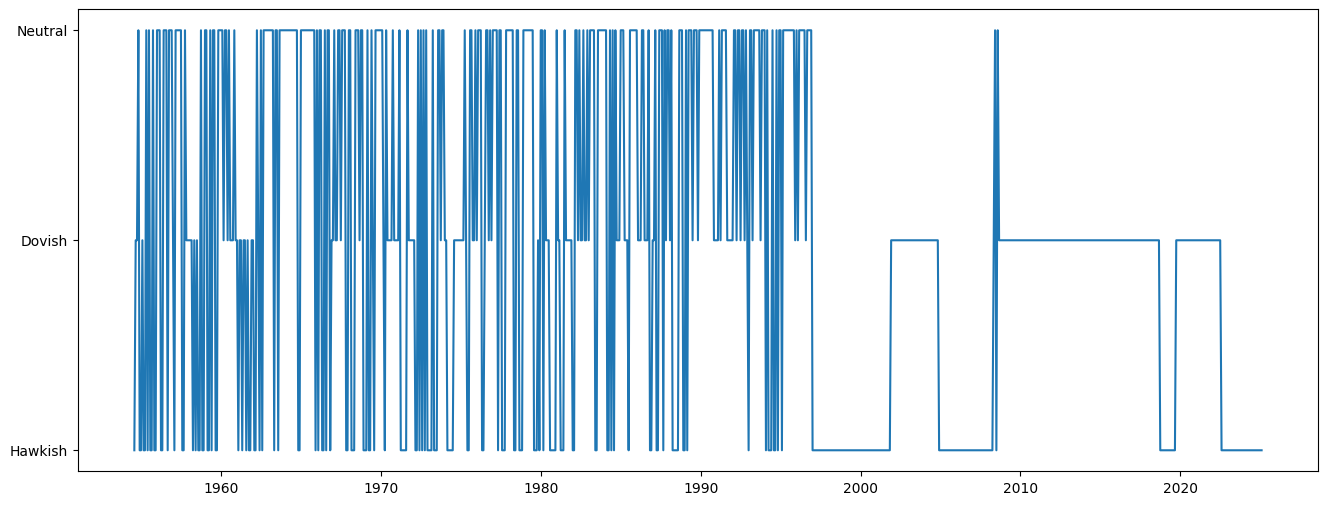

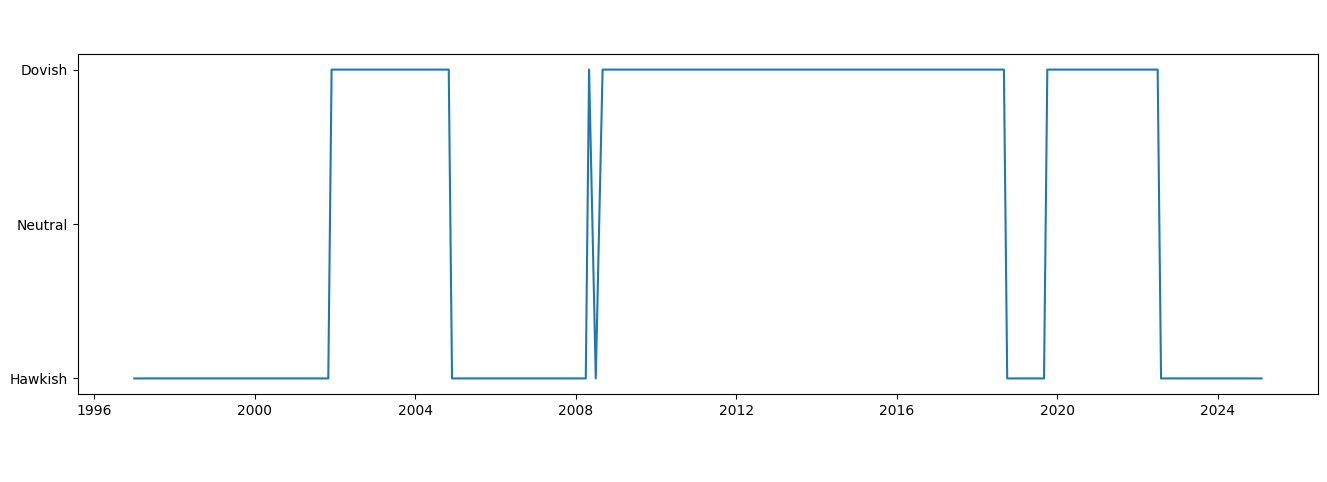

In [11]:
policy_map = {"Hawkish": 0, "Neutral": 1, "Dovish": 2}
fed_funds_hs["Policy_Num"] = fed_funds_hs["Policy"].map(policy_map)

temp_fed = fed_funds_hs[fed_funds_hs["Year"] > 1996]

plt.figure(figsize=(16,6))
plt.plot(fed_funds_hs["observation_date"], fed_funds_hs["Policy"], marker='', linestyle='-')
plt.show()

fig, axes = plt.subplots(3, 1, figsize=(16, 6), gridspec_kw={'height_ratios': [0.05, 1,0.15]})
axes[0].axis("off")
axes[2].axis("off")
axes[1].set_yticks([0, 1, 2])
axes[1].set_yticklabels(['Hawkish', 'Neutral', 'Dovish'])
axes[1].plot(temp_fed["observation_date"], temp_fed["Policy_Num"], marker='', linestyle='-')
#plt.savefig("states_switching_FFR_3.pdf", bbox_inches="tight")
plt.show()

## Markov Chains with Experimental Data

We now want to test whether the empirically derived transition matrix can be meaningfully applied to alternative data sources—namely, **Inflation** and **Unemployment**.

In other words, we aim to assess whether these macroeconomic indicators, when classified into monetary policy regimes and plugged into a Markov Chain, produce a sequence of states similar to the one obtained from the Fed Funds Rate (FFR), which serves as a proxy for actual monetary policy decisions.

If the experimental sequence approximates the FFR-derived sequence well, we will proceed to forecast potential future states using this new variable set.

---

### Classification Criteria

To assign each monthly observation to a policy regime based on inflation and unemployment, we adopt the following logic:

1. **Hawkish Monetary Policy (Restrictive):**
   - High Inflation
   - Low Unemployment
   

2. **Dovish Monetary Policy (Expansionary):**
   - Low Inflation
   - High Unemployment

---

This heuristic reflects the traditional **Phillips Curve**, which postulates an inverse relationship between inflation and unemployment. However, in practice, this relationship is not always observed. For instance:

- **The first empirical failure** of the Phillips Curve came during the **1970s oil crisis**, when high inflation and high unemployment occurred simultaneously.

- Since then, **expectations** have been incorporated into economic models to better explain such anomalies.

---

### Ambiguous Cases

In real-world macroeconomics, not all combinations of inflation and unemployment are easily classifiable. In this model:

- Ambiguous or mixed scenarios are assigned to the **Neutral** regime.
- This simplification is necessary for clean classification, but it abstracts away from complex policy dilemmas such as:

#### Examples:
- **Stagflation** (High Inflation + High Unemployment):
  - A difficult policy challenge: stimulating demand might worsen inflation, while fighting inflation could hurt employment.
  
- **Low Inflation + Low Unemployment**:
  - A rare case, as low unemployment tends to drive inflation up.
  - However, depending on the fixed thresholds used for classification, this situation may still occur in our model.

This trade-off highlights the limitations of deterministic classification and emphasizes the need for interpretative caution when modeling real-world economic regimes.


### Policy Classification Function

The following function defines thresholds for classifying macroeconomic conditions into monetary policy regimes:

- **Dovish:** Low inflation and high unemployment.
- **Hawkish:** High inflation and low unemployment.
- **Neutral:** Any ambiguous case (e.g., stagflation or low-low regimes).

This simplification reflects a stylized view of monetary policy logic derived from the Phillips Curve and other macroeconomic theory.


In [13]:
def my_policy(inflation, unemployment, h_inf = 2.75, l_inf = 1.5, h_un = 6, l_un = 4):
    if inflation < l_inf and unemployment > h_un:
        return "Dovish"
    elif inflation > h_inf and unemployment < l_un:
        return "Hawkish"
    else:
        return "Neutral"

### Creating the Experimental Dataset

We build a new DataFrame combining historical monthly values for:
- **Inflation rate** (CPI)
- **Unemployment rate**

We then apply a simple rule-based classification to infer the monetary policy stance based on these inputs.


In [14]:
policy_experiment = pd.DataFrame()
policy_experiment["Date"] = inflation_rate_hs["observation_date"]
policy_experiment["Inflation"] = inflation_rate_hs["CPIAUCSL_PC1"]
policy_experiment["Unemployment"] = unemp_rate_hs["UNRATE"]

# apply the function
policy_experiment["Policy"] = policy_experiment.apply(lambda row: my_policy(row['Inflation'], row['Unemployment']), axis=1)


### Estimating the Transition Matrix (Inflation + Unemployment)

We compute the transition matrix for this alternative classification and compare it to the Fed Funds baseline.

This helps evaluate whether these proxies can produce stable and coherent policy regime sequences.


In [15]:
# proviamo a tirare fuori anche qui la transition matrix per confrontarle
states = policy_experiment['Policy'].unique().tolist()
transition_experiment = pd.DataFrame(0, index = states, columns = states)
T_matrix_experiment = transition_matrix(policy_experiment, transition_experiment)
print(T_matrix_experiment)

# Matrice di transizione degli ultimi 30 anni
policy_experiment["Year"] = policy_experiment["Date"].dt.year
exp_temp = policy_experiment[policy_experiment["Year"] > 1996]
T_matrix_experiment_onlynew = transition_matrix(exp_temp, transition_experiment)
print(T_matrix_experiment_onlynew)

          Neutral    Dovish   Hawkish
Neutral  0.969274  0.015363  0.015363
Dovish   0.207547  0.792453  0.000000
Hawkish  0.141026  0.000000  0.858974
          Neutral    Dovish   Hawkish
Neutral  0.964358  0.018330  0.017312
Dovish   0.202247  0.797753  0.000000
Hawkish  0.150442  0.000000  0.849558


### Comparing Policy Sequences Over Time

Let’s visually compare the sequence of policy regimes derived from:
- The Fed Funds Rate (green line)
- Inflation and Unemployment (blue line)

We want to assess whether the two sequences show similar transitions and persistence, especially in the post-1996 period.


/var/folders/ln/8m1n1x0d0692gmx_80h6n4zw0000gn/T/ipykernel_2308/3832949009.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_temp["Policy_Num"] = exp_temp["Policy"].map(policy_map)


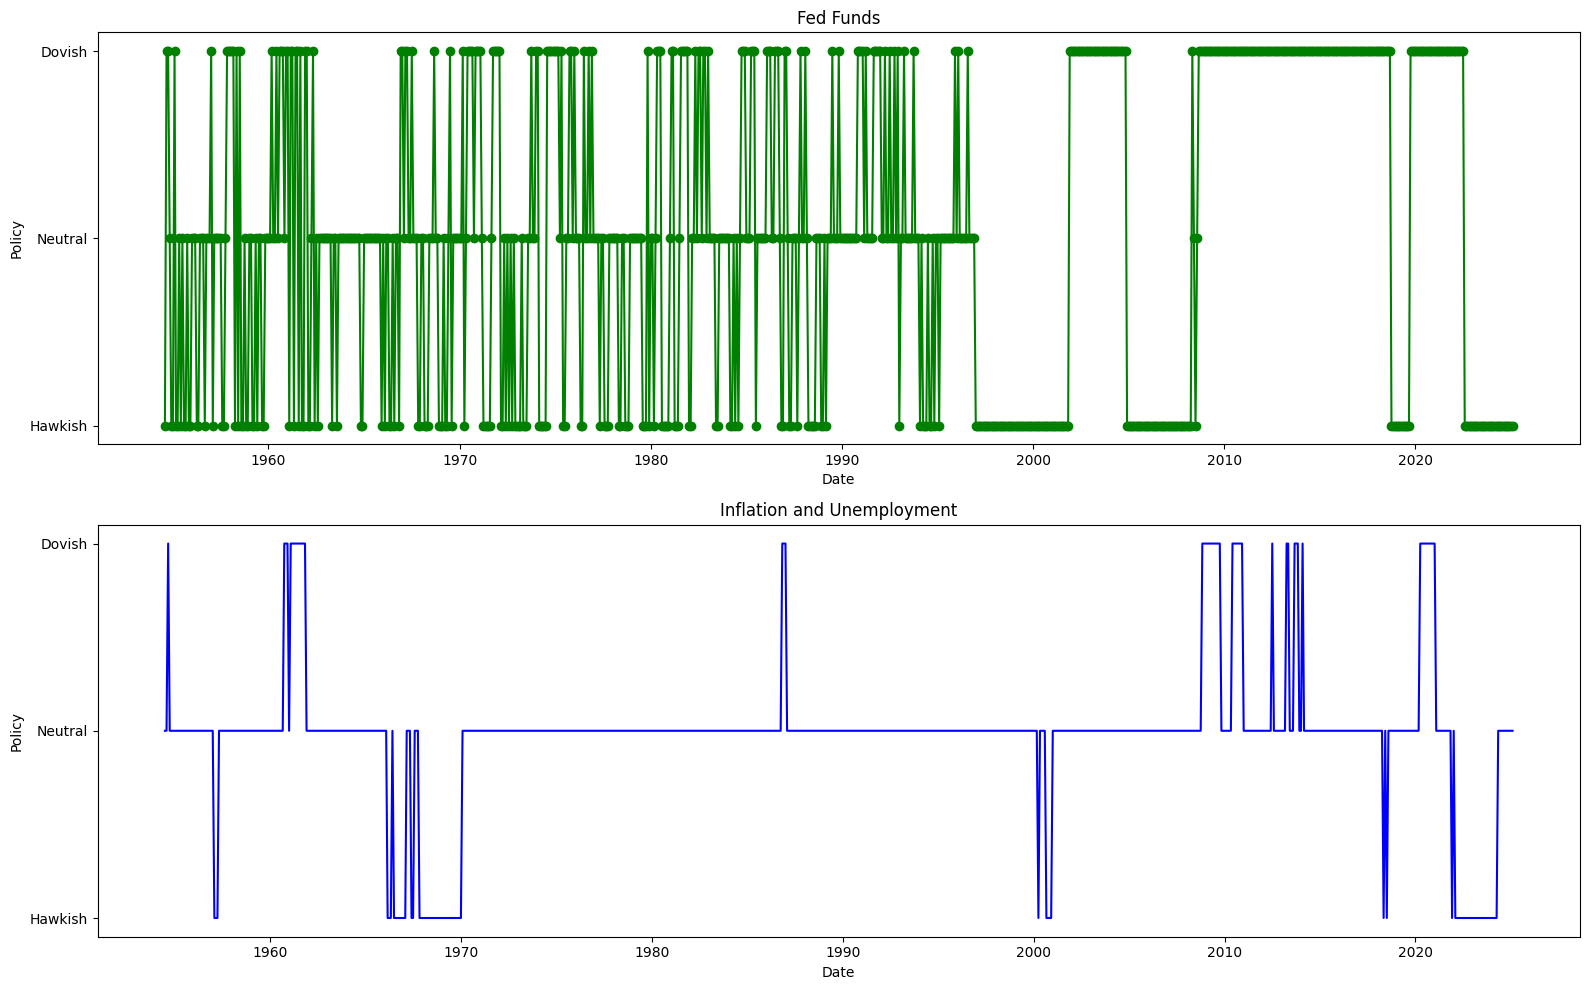

In [16]:
policy_map = {"Hawkish": 0, "Neutral": 1, "Dovish": 2}
fed_funds_hs["Policy_Num"] = fed_funds_hs["Policy"].map(policy_map)
policy_experiment["Policy_Num"] = policy_experiment["Policy"].map(policy_map)
exp_temp["Policy_Num"] = exp_temp["Policy"].map(policy_map)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

axes[1].plot(policy_experiment["Date"], policy_experiment["Policy_Num"], marker='', linestyle='-', color = 'blue')
axes[1].set_title("Inflation and Unemployment")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Policy")
axes[1].set_yticks([0, 1, 2])
axes[1].set_yticklabels(['Hawkish', 'Neutral', 'Dovish'])

# Secondo subplot
axes[0].plot(fed_funds_hs["observation_date"], fed_funds_hs["Policy_Num"], marker='o', linestyle='-', color = 'green')
axes[0].set_title("Fed Funds")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Policy")
axes[0].set_yticks([0, 1, 2])
axes[0].set_yticklabels(['Hawkish', 'Neutral', 'Dovish'])

# Ottimizza la disposizione dei grafici
plt.tight_layout()

# Mostra il grafico
plt.show()

### Overlaying the Two Sequences (Post-1996)

We now overlay the two policy classifications (FFR and Inflation/Unemployment).

> To better assess the volatility and stability of this experimental policy sequence, we isolate the Inflation + Unemployment classification alone for the last 30 years.

This allows us to spot convergence and divergence across time, highlighting episodes where macro indicators may fail to capture the actual policy stance.


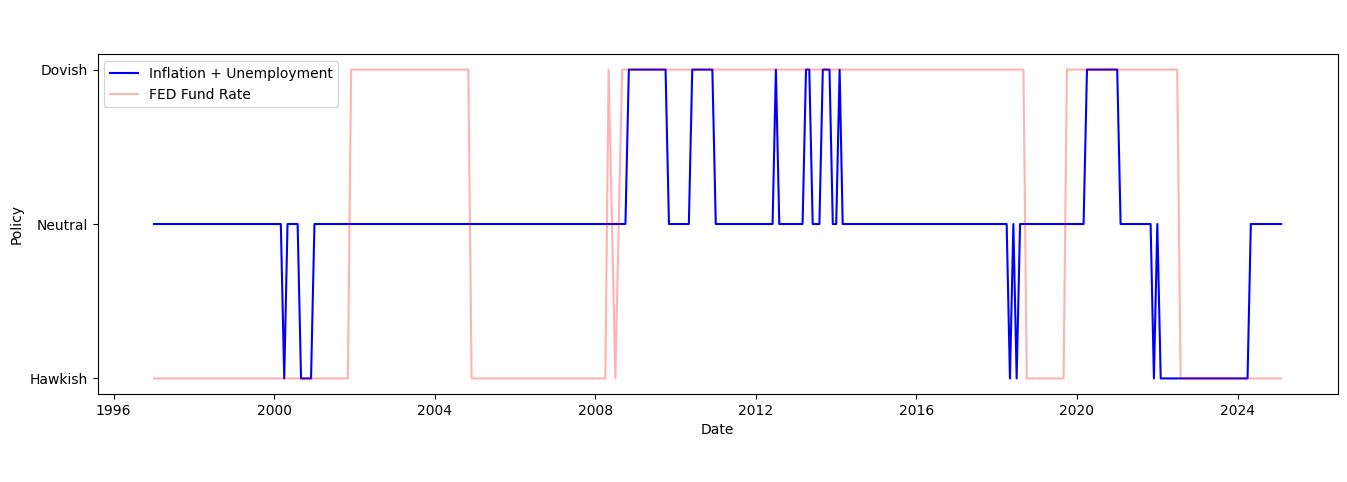

In [20]:
# Plottati insieme
fig, axes = plt.subplots(3, 1, figsize=(16, 6), gridspec_kw={'height_ratios': [0.05, 1,0.15]})
axes[0].axis("off")
axes[2].axis("off")
axes[1].plot(exp_temp["Date"], exp_temp["Policy_Num"], marker='', linestyle='-', color = 'blue', label = 'Inflation + Unemployment')
axes[1].plot(temp_fed["observation_date"], temp_fed["Policy_Num"], marker='', linestyle='-', color = 'red',alpha=0.3,label = 'FED Fund Rate')
axes[1].set_yticks([0, 1, 2])
axes[1].set_yticklabels(['Hawkish', 'Neutral', 'Dovish'])
axes[1].set_ylabel("Policy")
axes[1].set_xlabel("Date")
axes[1].legend(loc="best")
#plt.savefig("inf_un_3.pdf", bbox_inches="tight")
plt.show()

# only last 30 years
# fig, axes = plt.subplots(3, 1, figsize=(16, 6), gridspec_kw={'height_ratios': [0.05, 1,0.15]})
# axes[0].axis("off")
# axes[2].axis("off")
# axes[1].set_yticks([0, 1, 2])
# axes[1].set_yticklabels(['Hawkish', 'Neutral', 'Dovish'])
# axes[1].plot(exp_temp["Date"], exp_temp["Policy_Num"], marker='', linestyle='-')
#plt.savefig("states_switching_IU.pdf", bbox_inches="tight")
# plt.show()


### Enhancing the Model: Adding Real GDP Growth

In this section, we add **Real GDP Growth (% change)** to the previous two indicators.

Rationale:
- GDP adds information about business cycle dynamics.
- It helps differentiate between stable but sluggish periods and actual expansion.

The original GDP data is quarterly, so we interpolate to a monthly frequency for consistency.


In [21]:
#### What if we add real GDP growth??
gdp = pd.read_excel('GDPC1_PC1.xlsx',sheet_name='Quarterly',usecols='A:B')
gdp['observation_date'] = pd.to_datetime(gdp['observation_date'], errors='coerce')
print(gdp)

    observation_date  GDPC1_PC1
0         1954-07-01   -0.76833
1         1954-10-01    2.72862
2         1955-01-01    6.17020
3         1955-04-01    7.78024
4         1955-07-01    8.01592
..               ...        ...
277       2023-10-01    3.19622
278       2024-01-01    2.90183
279       2024-04-01    3.03685
280       2024-07-01    2.71877
281       2024-10-01    2.53368

[282 rows x 2 columns]


### Loading and Interpolating Real GDP Growth

We load quarterly GDP growth and interpolate it linearly to obtain a monthly series.

This step is necessary to align GDP data with the monthly inflation and unemployment series.


In [22]:
### Interpolazione dei dati di crescita del GDP reale
### trimestrale

gdp = pd.read_excel('GDPC1_PC1.xlsx', sheet_name='Quarterly', usecols='A:B')

gdp['observation_date'] = pd.to_datetime(gdp['observation_date'], errors='coerce')

date_range = pd.date_range(start=gdp['observation_date'].min(), end=gdp['observation_date'].max(), freq='ME')

monthly_df = pd.DataFrame(date_range, columns=['monthly'])

monthly_df['quarter_value'] = np.nan

# Per ogni mese, assegna il valore trimestrale più vicino
for i in range(1, len(gdp)):
    start_date = gdp['observation_date'].iloc[i-1]
    end_date = gdp['observation_date'].iloc[i]
    
    monthly_dates = pd.date_range(start=start_date, end=end_date, freq='ME')
    start_value = gdp['GDPC1_PC1'].iloc[i-1]
    end_value = gdp['GDPC1_PC1'].iloc[i]
    
    for month_date in monthly_dates:
        proportion = (month_date - start_date) / (end_date - start_date)
        interpolated_value = start_value + proportion * (end_value - start_value)
        
        monthly_df.loc[monthly_df['monthly'] == month_date, 'interpolated_value'] = interpolated_value

gdp_monthly = monthly_df[['monthly', 'interpolated_value']]
print(gdp_monthly.tail(20))

last_date_gdp = gdp_monthly['monthly'].max()
# trim inflation and unmeployment
inf_3 = inflation_rate_hs[inflation_rate_hs['observation_date'] <= last_date_gdp]
un_3 = unemp_rate_hs[unemp_rate_hs['observation_date'] <= last_date_gdp]


       monthly  interpolated_value
823 2023-02-28            2.634384
824 2023-03-31            2.823364
825 2023-04-30            2.959115
826 2023-05-31            3.097713
827 2023-06-30            3.231839
828 2023-07-31            3.223237
829 2023-08-31            3.209729
830 2023-09-30            3.196656
831 2023-10-31            3.100223
832 2023-11-30            3.004227
833 2023-12-31            2.905030
834 2024-01-31            2.946342
835 2024-02-29            2.989370
836 2024-03-31            3.035366
837 2024-04-30            2.935484
838 2024-05-31            2.827127
839 2024-06-30            2.722265
840 2024-07-31            2.658415
841 2024-08-31            2.596047
842 2024-09-30            2.535692


### Enhanced Policy Classification Function

This updated function includes GDP growth as a third decision variable.

- **Dovish:** Low inflation + high unemployment **or** low GDP growth.
- **Hawkish:** High inflation + low unemployment **or** high GDP growth.
- **Neutral:** All ambiguous or intermediate cases.

The goal is to capture more realistic transitions and improve stability in state classification.


In [23]:
def my_policy3(inflation, unemployment, gdp_growth, 
              h_inf=2.75, l_inf=1.5, h_un=6, l_un=4, 
              h_gdp=3.5, l_gdp=1.0):
    
    if (inflation < l_inf and unemployment > h_un) or gdp_growth < l_gdp:
        return "Dovish"

    elif (inflation > h_inf and unemployment < l_un) or gdp_growth > h_gdp:
        return "Hawkish"
    
    else:
        return "Neutral"

### Building the Dataset (Inflation + Unemployment + GDP)

We construct a new DataFrame to store monthly values for all three macro variables and classify each observation into a policy regime using `my_policy3()`.


In [24]:
exp_3 = pd.DataFrame()
exp_3["Date"] = gdp_monthly["monthly"]
exp_3["GDP"] = gdp_monthly["interpolated_value"]
exp_3["Inflation"] = inf_3["CPIAUCSL_PC1"]
exp_3["Unemployment"] = un_3["UNRATE"]

exp_3["Policy"] = exp_3.apply(lambda row: my_policy3(row['Inflation'], row['Unemployment'], row['GDP']), axis=1)

print(exp_3)


          Date       GDP  Inflation  Unemployment   Policy
0   1954-07-31  0.371980    0.26129           5.8   Dovish
1   1954-08-31  1.550300    0.00000           6.0  Neutral
2   1954-09-30  2.690610   -0.29751           6.1   Dovish
3   1954-10-31  3.850874   -0.85343           5.7  Hawkish
4   1954-11-30  4.973129   -0.26071           5.3  Hawkish
..         ...       ...        ...           ...      ...
838 2024-05-31  2.827127    3.23887           4.0  Neutral
839 2024-06-30  2.722265    2.97009           4.1  Neutral
840 2024-07-31  2.658415    2.93846           4.2  Neutral
841 2024-08-31  2.596047    2.61091           4.2  Neutral
842 2024-09-30  2.535692    2.43254           4.1  Neutral

[843 rows x 5 columns]


### Transition Matrix: 3-Variable Model

We now estimate the transition matrix for the model using inflation, unemployment, and GDP.

We compare this matrix to previous ones to assess:
- Stability of transitions
- Smooth movement toward neutral state
- Realistic rare transitions (e.g., direct jumps)


In [69]:
T_matrix_experiment_3 = transition_matrix(exp_3, transition_experiment)
print(T_matrix_experiment_3)

# Last 30 years
exp_3["Year"] = exp_3["Date"].dt.year
exp_3_30 = exp_3[exp_3["Year"] > 1996]
exp_3_30["Policy_Num"] = exp_3_30["Policy"].map(policy_map)

T_matrix_experiment_3_onlynew = transition_matrix(exp_3_30, transition_experiment)
print(T_matrix_experiment_3_onlynew)


          Neutral    Dovish   Hawkish
Neutral  0.942924  0.028147  0.028929
Dovish   0.144033  0.843621  0.012346
Hawkish  0.077381  0.001984  0.920635
          Neutral    Dovish   Hawkish
Neutral  0.939100  0.031142  0.029758
Dovish   0.144781  0.841751  0.013468
Hawkish  0.076299  0.001623  0.922078


/var/folders/ln/8m1n1x0d0692gmx_80h6n4zw0000gn/T/ipykernel_1389/815244298.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_3_30["Policy_Num"] = exp_3_30["Policy"].map(policy_map)


## Comparing All Three Models

Final visualization: we plot all three policy sequences—derived from FFR, Inflation + Unemployment, and the full model including GDP—on the same timeline.

This side-by-side comparison provides a comprehensive view of how each approach aligns with the observed Fed Funds policy regimes.


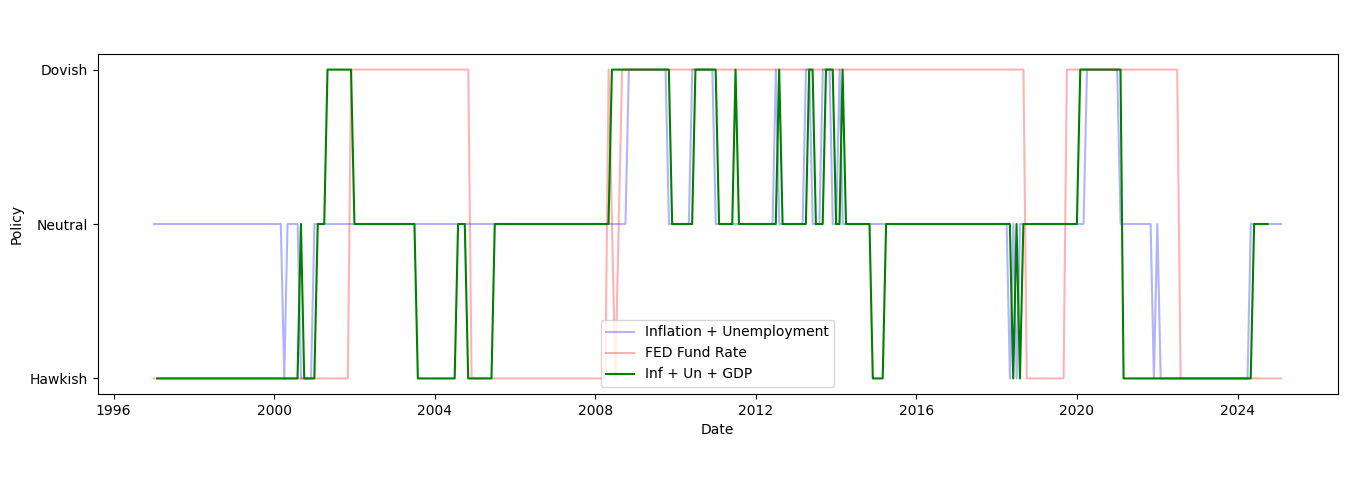

In [71]:
fig, axes = plt.subplots(3, 1, figsize=(16, 6), gridspec_kw={'height_ratios': [0.05, 1,0.15]})
axes[0].axis("off")
axes[2].axis("off")
axes[1].plot(exp_temp["Date"], exp_temp["Policy_Num"], marker='', linestyle='-', color = 'blue',alpha=0.3, label = 'Inflation + Unemployment')
axes[1].plot(temp_fed["observation_date"], temp_fed["Policy_Num"], marker='', linestyle='-', color = 'red',alpha=0.3,label = 'FED Fund Rate')
axes[1].plot(exp_3_30["Date"], exp_3_30["Policy_Num"], marker='', linestyle='-', color = 'green',label = 'Inf + Un + GDP')
axes[1].set_yticks([0, 1, 2])
axes[1].set_yticklabels(['Hawkish', 'Neutral', 'Dovish'])
axes[1].set_ylabel("Policy")
axes[1].set_xlabel("Date")
axes[1].legend(loc="best")
plt.savefig("inf_un_gdp_3.pdf", bbox_inches="tight")
plt.show()

## Key Takeaways and Limitations

This notebook demonstrated how to model U.S. Monetary Policy decisions using a Markov Chain approach, based on transitions between three regimes: Dovish, Neutral, and Hawkish.

We tested three sets of economic indicators:

1. **Fed Funds Rate (FFR)**  
   - Strong alignment with actual policy actions.  
   - However, it lacks smooth transitions through the Neutral state.

2. **Inflation and Unemployment**  
   - Allows for more realistic intermediate transitions and persistence.  
   - Slightly less stable; some business cycle phases are poorly matched.

3. **Inflation, Unemployment, and Real GDP Growth**  
   - Provides a balanced representation, capturing missing cycles.  
   - Models smooth transitions more effectively and aligns well with FFR-based classifications.  
   - Still subject to occasional inconsistencies in state changes.

### Main Observations

- Economic logic based on simple macro relationships (such as the Phillips Curve) can approximate real policy dynamics when formalized in a probabilistic framework.
- Empirical transition matrices enable simulation of future policy states.
- Accurately capturing the Neutral state is essential for realistic modeling.
- While the FFR alone reflects FED action well, composite indicators provide greater interpretability and flexibility.

### Model Limitations

- The Markov model is memoryless: it considers only the current state, ignoring historical trends and future expectations.
- Transition probabilities are assumed fixed, which does not account for structural policy shifts or changing macroeconomic regimes.
- Expectations, forward guidance, and external shocks—central to modern monetary policy—are excluded from this framework.
- The model is a simplified and stylized tool. It is useful for pedagogical purposes or baseline simulations, but not suitable for real-time policy analysis or forecasting.

### Future Directions

This framework can serve as a foundation for more advanced studies in regime-switching macroeconomic models. Possible extensions include:

- Hidden Markov Models (HMMs)
- Time-varying transition matrices
- Bayesian estimation or simulation-based forecasting
- Incorporating expectations via survey or market-based data

This work illustrates the potential and boundaries of applying discrete-time Markov processes to real-world economic policy classification.
